# Task for Today  

***

## Legendary Pokémon Classification  

Use a FeedForward Neural Network to predict if a given Pokémon is **legendary** or not, based on *Pokémon features*.


<img src="https://wallpapers.com/images/hd/legendary-pokemon-pictures-7yo7x0f1l2b2tu0r.jpg" width="800" height="500" alt="legendaries">

Data available at: https://github.com/Vaeliss/Pokemon_challenge/blob/main/pokemon.csv

Download the `pokemon.csv` file and put it in the file section of Colab.

# Challenge

TAs want to battle!

<img src="https://pokemongohub.net/wp-content/uploads/2023/06/grunts-1.jpg" width="400" height="300" alt="TAs">

Rules of the challenge:

- Gotta catch 'em all! ...But give priority to the legendaries.
- F1-score is usually the measure of choice for imbalanced datasets; however in this case we particularly want to avoid not "catching" legendaries. They're so rare, you might not have any more chances to catch 'em if they flee...
- In ML terms, we give recall more importance than precision for the task (check the whiteboard if you don't know their meaning).
- F2-score (i.e., [F-$\beta$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) with $\beta = 2$) is hence used as the main evaluation metric for your model.

- **TAs achieved a F2-score of 0.80. Can you beat them?!**

# Imports and dataset

In [3300]:
from xml.etree.ElementPath import xpath_tokenizer_re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from click.core import batch

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn, dtype
import torch.optim as optim

In [3301]:
_ = torch.manual_seed(42) # for a fair comparison, don't change the seed!

In [3302]:
data = pd.read_csv('Datasets/pokemon.csv')

In [3303]:
data

,dexnum,name,generation,type1,type2,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary
0,1025,Pecharunt,9,Poison,Ghost,0.3,0.3,88,88,160,88,88,88,600,1
1,1024,Terapagos,9,Normal,NaN,0.2,6.5,90,65,85,65,85,60,450,1
2,1023,Iron Crown,9,Steel,Psychic,1.6,156.0,90,72,100,122,108,98,590,0
3,1022,Iron Boulder,9,Rock,Psychic,1.5,162.5,90,120,80,68,108,124,590,0
4,1021,Raging Bolt,9,Electric,Dragon,5.2,480.0,125,73,91,137,89,75,590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5,Charmeleon,1,Fire,NaN,1.1,19.0,58,64,58,80,65,80,405,0
1021,4,Charmander,1,Fire,NaN,0.6,8.5,39,52,43,60,50,65,309,0
1022,3,Venusaur,1,Grass,Poison,2.0,100.0,80,82,83,100,100,80,525,0
1023,2,Ivysaur,1,Grass,Poison,1.0,13.0,60,62,63,80,80,60,405,0


In [3304]:
data_raw = data.copy() # usually, if memory allows it, it's a good idea to keep a raw version of your data

# Pre-processing / encoding

In [3305]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dexnum      1025 non-null   int64  
 1   name        1025 non-null   object 
 2   generation  1025 non-null   int64  
 3   type1       1025 non-null   object 
 4   type2       526 non-null    object 
 5   height      1025 non-null   float64
 6   weight      1025 non-null   float64
 7   hp          1025 non-null   int64  
 8   attack      1025 non-null   int64  
 9   defense     1025 non-null   int64  
 10  sp_atk      1025 non-null   int64  
 11  sp_def      1025 non-null   int64  
 12  speed       1025 non-null   int64  
 13  total       1025 non-null   int64  
 14  legendary   1025 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 120.2+ KB


In [3306]:
data.isna().sum()

dexnum          0
name            0
generation      0
type1           0
type2         499
height          0
weight          0
hp              0
attack          0
defense         0
sp_atk          0
sp_def          0
speed           0
total           0
legendary       0
dtype: int64

In [3307]:
data = data.drop(['dexnum', 'name', 'type2'], axis=1)
# dropping type 2 is actually a debeatable step, it may provide useful information
# data = data.drop(["#", "Name"], axis=1)

In [3308]:
data['legendary'] = data['legendary'].astype(int)
data['generation'] = data['generation'].astype(str)

In [3309]:
data.dtypes

generation     object
type1          object
height        float64
weight        float64
hp              int64
attack          int64
defense         int64
sp_atk          int64
sp_def          int64
speed           int64
total           int64
legendary       int64
dtype: object

Categorical variables are one-hot encoded

In [3310]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [3311]:
data = onehot_encode(data, 'type1', 't')
data = onehot_encode(data, 'generation', 'g')

In [3312]:
data.shape

(1025, 37)

## Splitting and Scaling

In [3313]:
data.columns # note that only the first 9 features are continuous now

Index(['height', 'weight', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def',
       'speed', 'total', 'legendary', 't_Bug', 't_Dark', 't_Dragon',
       't_Electric', 't_Fairy', 't_Fighting', 't_Fire', 't_Flying', 't_Ghost',
       't_Grass', 't_Ground', 't_Ice', 't_Normal', 't_Poison', 't_Psychic',
       't_Rock', 't_Steel', 't_Water', 'g_1', 'g_2', 'g_3', 'g_4', 'g_5',
       'g_6', 'g_7', 'g_8', 'g_9'],
      dtype='object')

In [3314]:
y = data['legendary']
X = data.drop('legendary', axis=1)

In [3315]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:9])
X = np.concatenate((X_scaled, np.array(X.iloc[:,9:])), axis=1)

In [3316]:
# keep the proportions for the split equal and specify a seed of 42, we want a fair fight!
# Note: end split should be 0.60,0.20,0.20 for train,valid,test
train_size = 0.6
valid_size = 0.4
test_size = 0.5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=valid_size, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=test_size,test_size=test_size, random_state=42, shuffle=True)

print('Train split:', 100*X_train.shape[0]/X.shape[0])
print('Test split:', 100*X_test.shape[0]/X.shape[0])
print('Valid split:', 100*X_valid.shape[0]/X.shape[0])

Train split: 60.0
Test split: 20.0
Valid split: 20.0


# Model definition

In [3317]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using {device} device")

Using mps device


### Define your model :

Choose yourself in the model:
- number of hidden layers
- number of neurons per layer (careful with input and output, these are not a choice)
- activation functions
- any other possible component among those seen so far in theory.

In [3318]:
class Model(nn.Module):
    def __init__(self, input_size, d_1, d_2,output_size, p): 
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, d_1)
        self.BN = nn.BatchNorm1d(d_1, momentum=0.1)
        self.fc2 = nn.Linear(d_1, d_2)
        self.dropout = nn.Dropout(p)
        self.fc4 = nn.Linear(d_2, output_size)

             
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.BN(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    

Instantiate your model and print it out

In [3319]:
# Hyperparameters
d_1 = 18
d_2 = 10
model = Model(36, d_1, d_2, 1, p=0.35)

print(model)

Model(
  (fc1): Linear(in_features=36, out_features=18, bias=True)
  (BN): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=18, out_features=10, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


### Hyperparameters:

Choose carefully your:
- learning rate (this is usually the most important hyperparameter to get right, but some optimizers are more forgiving than others)
- batch size
- number of epochs.
- other hyperparameters that you might need

In [3320]:
# Hyperparameter! - commented are the bests
learning_rate = 0.0023 #0.0023
batch_size = 64 #64
epochs = 200 #200

l1 = 0.0015 #0.0015
l2 = 0.00032 #0.00032
# 0.8252, momentum 0.1, p 0.35

### Loss function and optimizer:

- What's the appropriate loss function for the task?
- Decide which optimizer you want to use ([Documentation](https://pytorch.org/docs/stable/optim.html))

In [3321]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
loss_fn = nn.BCEWithLogitsLoss()

Define your TensorDatasets and DataLoaders; remember to use the appropriate dtype for your tensors.

In [3322]:
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.to_numpy()).float())
dataset_test = TensorDataset(torch.from_numpy(X_test).float(), torch.tensor(y_test.to_numpy()).float())
dataset_valid = TensorDataset(torch.from_numpy(X_valid).float(), torch.tensor(y_valid.to_numpy()).float())

trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validloader = DataLoader(dataset_valid, batch_size=len(dataset_valid))
testloader = DataLoader(dataset_test, batch_size=len(dataset_test))

In [3323]:
# Keep track of training and validation losses during training
train_loss_list = []
valid_loss_list = []

# Lists for performance report
all_predicted = []
all_targeted = []

print("We have", len(trainloader), "items for training and", len(validloader), "items for validation", len(testloader), "items for test")

We have 10 items for training and 1 items for validation 1 items for test


# Training

Implement your training and evaluation (for the validation set) loops

In [3324]:
# Put model into device
model.to(device)

for epoch in range(epochs):
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        
        # Get and flat data
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 36)
        
        # Set the gradient to 0
        optimizer.zero_grad()
        
        # Make a prediction
        output = model(data).squeeze(1)
        # Compute the loss function
        loss = loss_fn(output, target)
        
        # l1 normalization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1 * l1_norm
        
        # Backpropagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
    # Take loss value
    train_loss = loss.item()
    train_loss_list.append(train_loss)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            # Get and flat data
            data, target = data.to(device), target.to(device)
            data = data.reshape(-1,36)
            
            # Prediction
            output = model(data).squeeze(1)
            
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            valid_loss_list.append(validation_loss)
            
            #print(f"Epoch {epoch + 1}: Train loss: {round(train_loss, 4)}, Validation loss {round(validation_loss, 4)}")
            
# Compute test set
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        # Get and flat data
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1,36)
        
        # Prediction
        outputs = model(data)
        
        # Cast predicted into 0 or 1
        predicted = (outputs > 0).float()
        
        # Put predicted into lists for plots
        all_predicted.extend(predicted.cpu().numpy())
        all_targeted.extend(target.cpu().numpy())


# Results

### Plotting

Plot out the training and validation losses over the epochs

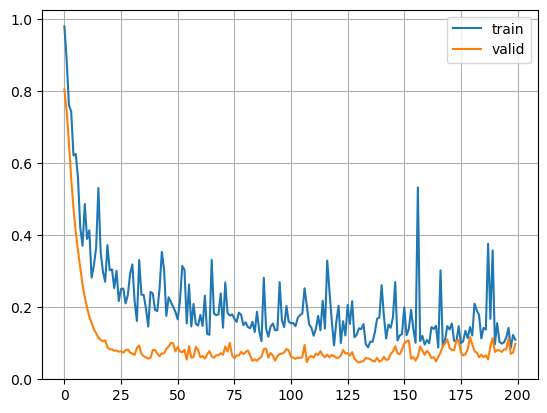

In [3325]:
plt.plot( train_loss_list , label='train')
plt.plot( valid_loss_list , label='valid')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Spikes are caused by batch size, less size equal more spikes

### Metrics

Print out appropriate metrics for the task

In [3326]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(all_targeted, all_predicted)
print("Accuracy:", round(accuracy, 4))

# Calculate confusion matrix
cm = confusion_matrix(all_targeted, all_predicted)
print("Confusion Matrix:\n", cm)

# Calculate F-beta score (e.g., F1-score)
f1_score = fbeta_score(all_targeted, all_predicted, beta=2)
print("F2-score:", round(f1_score, 4))

# Print classification report
report = classification_report(all_targeted, all_predicted)
print("Classification Report:\n", report)

Accuracy: 0.9561
Confusion Matrix:
 [[179   6]
 [  3  17]]
F2-score: 0.8252
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       185
         1.0       0.74      0.85      0.79        20

    accuracy                           0.96       205
   macro avg       0.86      0.91      0.88       205
weighted avg       0.96      0.96      0.96       205



In [3327]:
# Count wrong predictions
number_of_wrong_predictions = len(all_targeted) - int(accuracy * len(all_targeted))
print(f'Number of wrong predictions: {number_of_wrong_predictions}')

Number of wrong predictions: 9


  Did you manage to catch them all?

______________________________________________________________________________

This notebook is largely inspired (with some improvements and updates) by a video featured on [Data Every Day](https://www.youtube.com/watch?v=3Fr1npNxkJk).